In [10]:
# lunar lander with DQN
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

# https://huggingface.co/learn/deep-rl-course/unit1/hands-on?fw=pt
from stable_baselines3 import PPO, A2C, DQN

# set up the environment
vec_env = make_vec_env("LunarLander-v2", 
                        n_envs=38, 
                        env_kwargs=dict(
                            continuous = False,
                            gravity = -10.0,
                            enable_wind = False,
                            wind_power = 15.0,
                            turbulence_power = 1.5,
                        ))
eval_env = gym.make("LunarLander-v2", render_mode='rgb_array', 
                        continuous = False,
                        gravity = -10.0,
                        enable_wind = False,
                        wind_power = 15.0,
                        turbulence_power = 1.5,
                        )

(array([ 0.01133566,  1.3865806 ,  0.56753504, -0.5534942 , -0.01113833,
       -0.09066886,  0.        ,  0.        ], dtype=float32), -0.21288300868746887, False, False, {})
(array([ 0.01688366,  1.3735235 ,  0.55730355, -0.5803427 , -0.01361459,
       -0.04952928,  0.        ,  0.        ], dtype=float32), -0.16293506671578825, False, False, {})


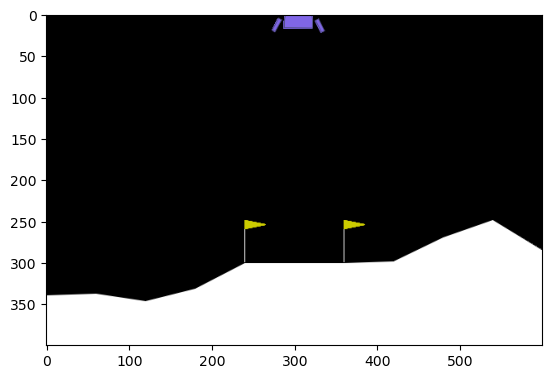

In [11]:
# run action 1 in eval_env
eval_env.reset(seed=0)
print(eval_env.step(1))
print(eval_env.step(1))
plt.imshow(eval_env.render())

In [40]:

model_PPO = PPO(
    policy="MlpPolicy",
    env=vec_env,
    n_steps=1024,
    batch_size=64,
    n_epochs=4,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    verbose=1,
    device='mps'
)

model_PPO.learn(total_timesteps=100_000)
model_PPO.save("models/ppo_lunarlander")


Using mps device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.4     |
|    ep_rew_mean     | -180     |
| time/              |          |
|    fps             | 4951     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 38912    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.7        |
|    ep_rew_mean          | -138        |
| time/                   |             |
|    fps                  | 1562        |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008028228 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0022      |
|    learning

In [37]:

model_A2C = A2C(
    policy="MlpPolicy",
    env=vec_env,
    n_steps=512, # number of steps to unroll for each environment
    gamma=0.99, # discount factor, higher means more focus on the future
    gae_lambda=0.99, # higher means more focus on the future
    ent_coef=0.05, # entropy coefficient, higher means more exploration
    verbose=1,
    device='mps'

    )
    
model_A2C.learn(total_timesteps=3_00_000)
model_A2C.save("models/a2c_lunarlander")

# close progress_bar



Using mps device


In [12]:

# results = {}
# for n_steps in np.logspace(2, 6, 10, dtype=int):

model_DQN = DQN(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=1e-3, # control the learning rate
    buffer_size=30_000, # control the size of the replay buffer, the larger the better
    learning_starts=1_00, # control the number of steps before learning starts
    batch_size=64, # control the batch size for each gradient update
    tau=0.3, # control the rate at which the target network is updated towards the target
    gamma=0.99, # control the discount factor
    train_freq=38, # control the frequency of training updates, i.e. number of steps between two updates
    gradient_steps=4, # control the number of gradient steps after each rollout
    verbose=1, # control the verbosity
    device='mps', # control the hardware to use, 'cpu' or 'cuda'
    target_update_interval=500, # control the frequency of target network updates
    exploration_initial_eps=1.0, # initial value for epsilon in epsilon-greedy exploration
    exploration_final_eps=0.01, # final value for epsilon in epsilon-greedy exploration
    max_grad_norm=10, # control the maximum norm of the gradient
)
n_steps = 1_000_000
model_DQN.learn(total_timesteps=n_steps)
model_DQN.save("models/dqn_lunarlander")







Using mps device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 59.8     |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2583     |
|    time_elapsed     | 0        |
|    total_timesteps  | 2318     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1        |
|    n_updates        | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 61.1     |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2588     |
|    time_elapsed     | 0        |
|    total_timesteps  | 2394     |
----------------------------------
----------------------------------
| rollout/            |          |
|  

In [13]:
# SCORING
model = DQN.load("models/dqn_lunarlander")

from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")


/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-115.33 +/- 19.53


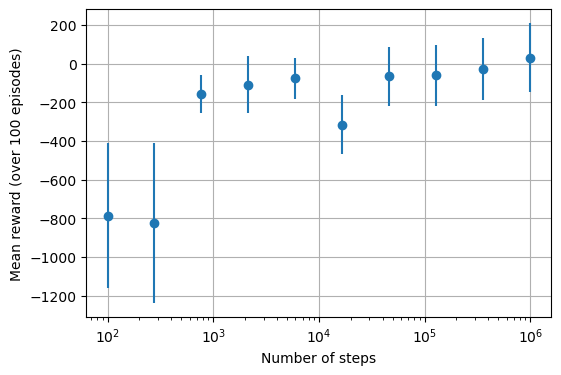

In [34]:
# plot results
plt.figure(figsize=(6, 4))
plt.errorbar(results.keys(), [r[0] for r in results.values()], yerr=[r[1] for r in results.values()], fmt='o')
plt.xscale('log')
plt.xlabel('Number of steps')
plt.ylabel('Mean reward (over 100 episodes)')
plt.grid()
plt.savefig('dqn_lunarlander_reward.png', dpi=300)

MovieWriter Pillow unavailable; using Pillow instead.


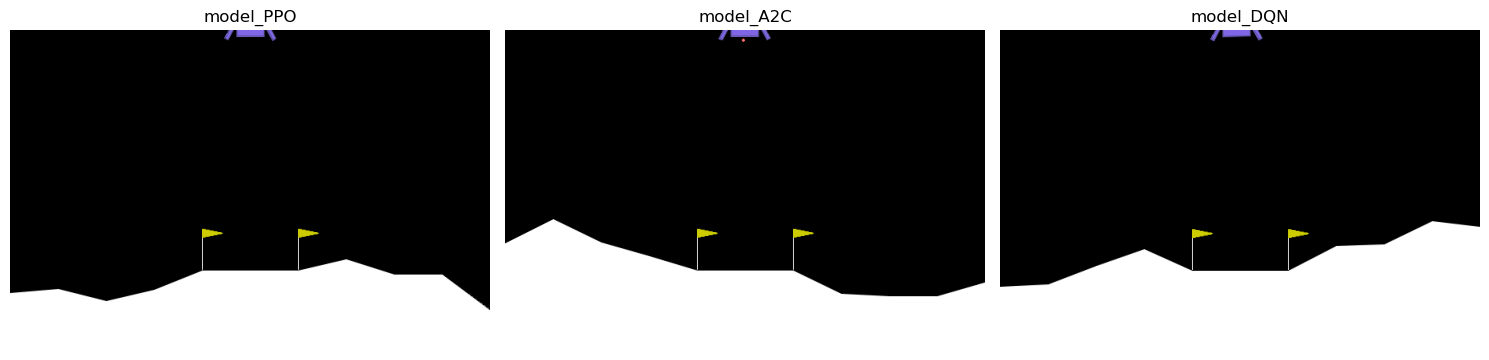

In [38]:
# get list of states
n_frames = 50
show_every = 5
frames = {}

models = ['model_PPO', 'model_A2C', 'model_DQN']

def get_model(model_name):
    if model_name == 'model_PPO':
        model = PPO.load("models/ppo_lunarlander")

    elif model_name == 'model_A2C':
        model = A2C.load("models/a2c_lunarlander")

    elif model_name == 'model_DQN':
        model = DQN.load("models/dqn_lunarlander")

    return model

for model_name in models:
    frames[model_name] = []
    model = get_model(model_name)
    state, _ = eval_env.reset()
    for i in range(n_frames*show_every):
        
        action, _ = model.predict(state, deterministic=True)
        state, _, _, _, _= eval_env.step(action)
        if i % show_every == 0:
            frames[model_name].append(eval_env.render())

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
from matplotlib import animation
from IPython.display import HTML


def animate(i):
    print(i/n_frames, end='\r')
    for axi, model_name in zip(ax, models):
        axi.imshow(frames[model_name][i])
        axi.set_title(model_name)
        axi.set_axis_off()
    fig.tight_layout()
    return fig

anim = animation.FuncAnimation(fig, animate, frames=n_frames, )
anim.save('lunar_lander.gif', writer='Pillow', fps=30)
    


In [ ]:
len(frames['model_PPO'])

200